NJW:
1. sim matrix -> nule na dijagonali
2. normalized l
3. " Form the matrix U = [u1 u2...uK]by stacking the eigenvectors in columns"
4. renomalizing Y da dobijem U: Yij = Uij / sqrt(suma(Uij^2))
5. K-Means


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random


import importlib
#--------------------import class indirectly so itt reflects the changes
import NJWAlgorithm
importlib.reload(NJWAlgorithm)
SpectralClusteringNJW = NJWAlgorithm.SpectralClusteringNJW
import KMeansAlogrithm
importlib.reload(KMeansAlogrithm)

import warnings
warnings.filterwarnings("ignore")


In [4]:
clusterer = SpectralClusteringNJW(sigma_I=50, sigma_X=100, r=20, max_clusters =4)
clusterer.load_image('images/eagle_30px.png')
segmented = clusterer.segment_image()
clusterer.visualize()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

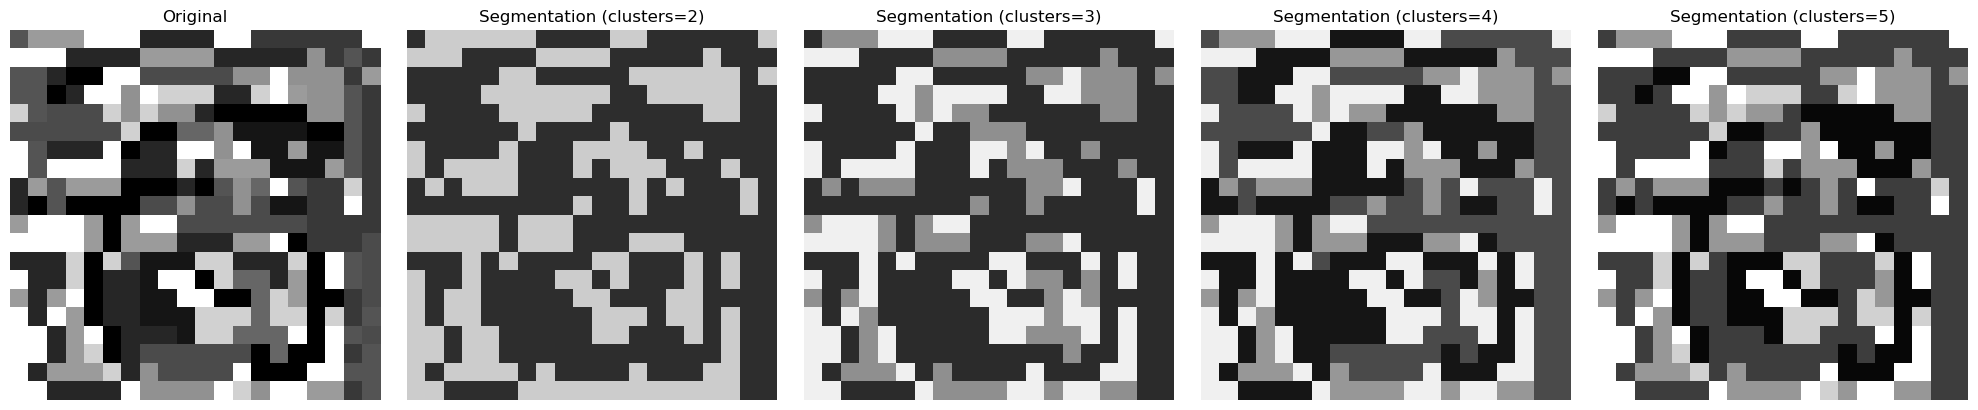

In [ ]:
# različiti max_clusters
max_clusters_values = [2,3,4,5]  
fig, axs = plt.subplots(1, len(max_clusters_values) + 1, figsize=(20, 4))
clusterer = SpectralClusteringNJW(sigma_I=0.1, sigma_X=5.0, r=10, max_clusters =1)
clusterer.load_image('images/image3.png') 

axs[0].imshow(clusterer.img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')

for idx, m in enumerate(max_clusters_values):
        clusterer = SpectralClusteringNJW(sigma_I=50, sigma_X=100, r=20, max_clusters =m)
        clusterer.load_image('images/image3.png')
        segmented = clusterer.segment_image()
        # ------------------------------------------------------  custom set boja ----------------------------
        cmap_custom = clusterer.average_color()
        axs[idx+1].imshow(segmented, cmap=cmap_custom)
        axs[idx+1].set_title(f'Segmentation (clusters={m})')
        axs[idx+1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def visualize_line(image_name, values, custom):
    fig, axs = plt.subplots(1, len(values) + 1, figsize=(20, 4))

    clusterer = SpectralClusteringNJW(sigma_I=0.1, sigma_X=5.0, r=10, max_clusters =1)
    clusterer.load_image(image_name) 

    axs[0].imshow(clusterer.img, cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')

    for idx, m in enumerate(values):
        clusterer = SpectralClusteringNJW(sigma_I=50, sigma_X=100, r=20, max_clusters =m)
        clusterer.load_image(image_name)
        segmented = clusterer.segment_image()
        # ------------------------------------------------------  custom set boja ----------------------------
        if custom:
            cmap_custom = clusterer.average_color()
            axs[idx + 1].imshow(segmented, cmap=cmap_custom)
        else:
            axs[idx + 1].imshow(segmented, cmap='gray')
        axs[idx + 1].set_title(f'Segmentation (max_cluster={m})')
        axs[idx + 1].axis('off')

    plt.tight_layout()
    plt.show()

custom boje


KeyboardInterrupt: 

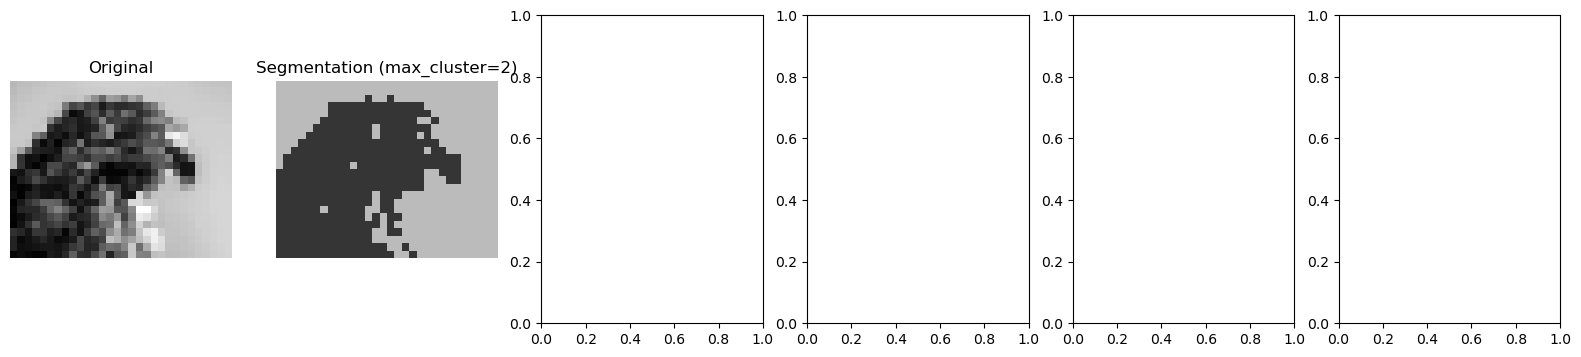

In [ ]:
print('custom boje')
visualize_line('images/eagle_30px.png', [2,4,6,8,10], True)
print('random boje')
visualize_line('images/eagle_30px.png', [2,4,6,8,10], False)

komentar: rezultati su dobri do 4 clustera, dalje se gubi - pozadina?? (built-in metoda ne daje rezultate dalje od 4 clustera na tom primjeru)
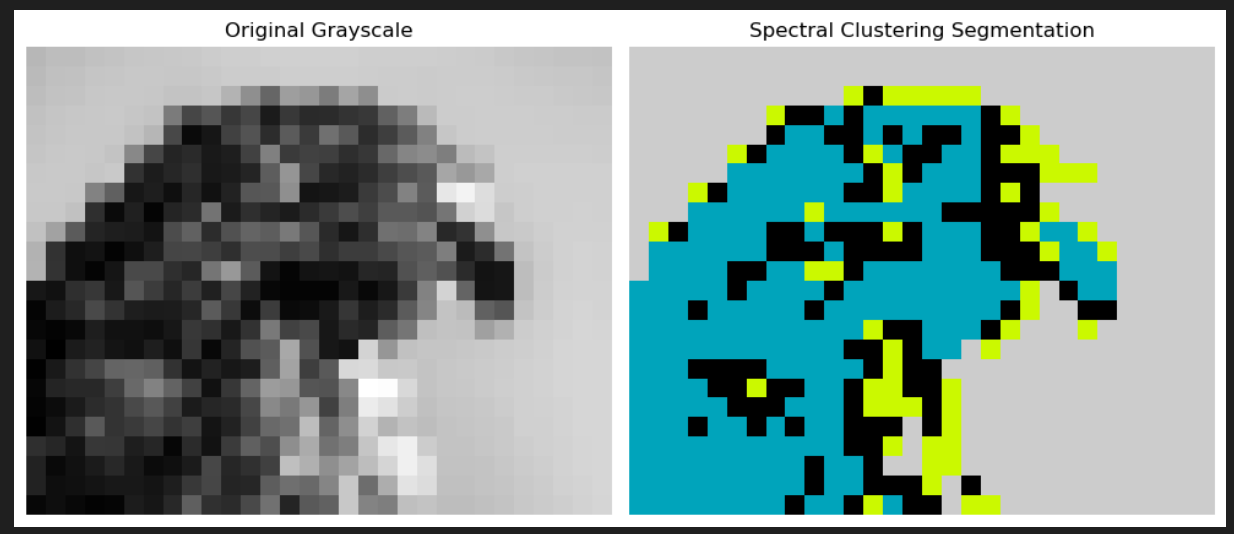

custom boje:


KeyboardInterrupt: 

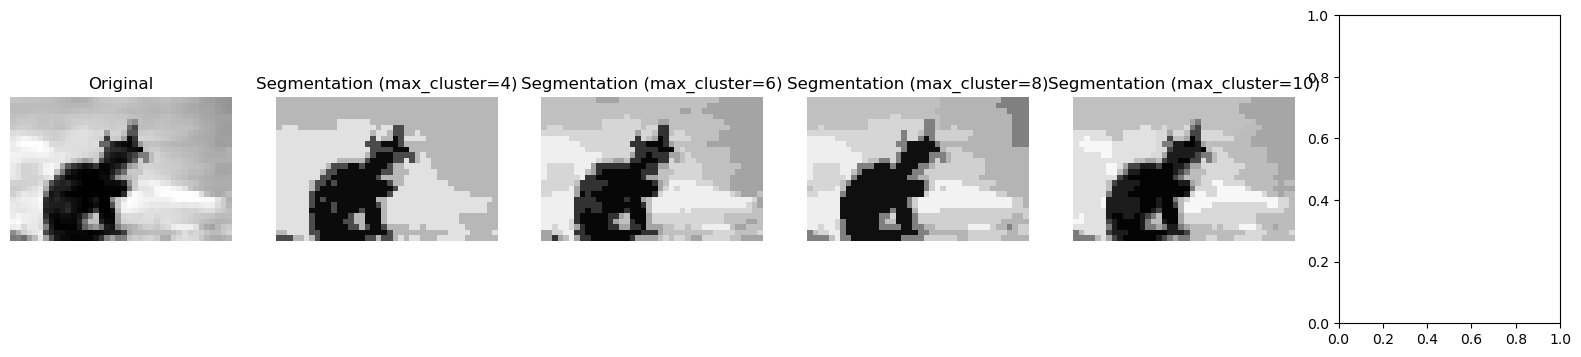

In [ ]:
print('custom boje:')
visualize_line('images/cat_40px.png', [4,6,8,10,12], True)
print('random boje:')
visualize_line('images/cat_40px.png', [4,6,8,10,12], False)

In [ ]:
print('custom boje')
visualize_line('images/bird_40px.png', [4,6,8,10,12], True)
print('random boje')
visualize_line('images/bird_40px.png', [4,6,8,10,12], False)

custom boje


In [ ]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=50, factor=0.5, noise=0.05)

sc = SpectralClusteringNJW(sigma_I=0, sigma_X=0.1, r=1.0, max_clusters=2)
sc.load_2d_data(X)
clusters = sc.segment_image()

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=clusters.flatten(), cmap='coolwarm', edgecolors='k')
plt.title('Spectral Clustering on Concentric Circles')
plt.axis('equal')
plt.show()


KeyboardInterrupt: 